# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt


try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestNeighbors

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("datasets/train/X_train.txt")
y_train = np.loadtxt("datasets/train/y_train.txt").astype(int)

X_test = np.loadtxt("datasets/test/X_test.txt")
y_test = np.loadtxt("datasets/test/y_test.txt").astype(int)

In [3]:

assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [4]:

X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

In [5]:
n_classes = np.unique(y).size

In [6]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:

pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

In [8]:

print(f"Число компонент: {pca.n_components_}")
print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.4f}")

Число компонент: 65
Объясненная дисперсия: 0.9005


**Ответ: 65**

**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

In [9]:

first_component_variance = pca.explained_variance_ratio_[0] * 100
print(f"Первая компонента: {first_component_variance:.2f}%")
print(f"Округленно: {round(first_component_variance)}%")

Первая компонента: 50.74%
Округленно: 51%


Визуализируйте данные в проекции на первые две главные компоненты.

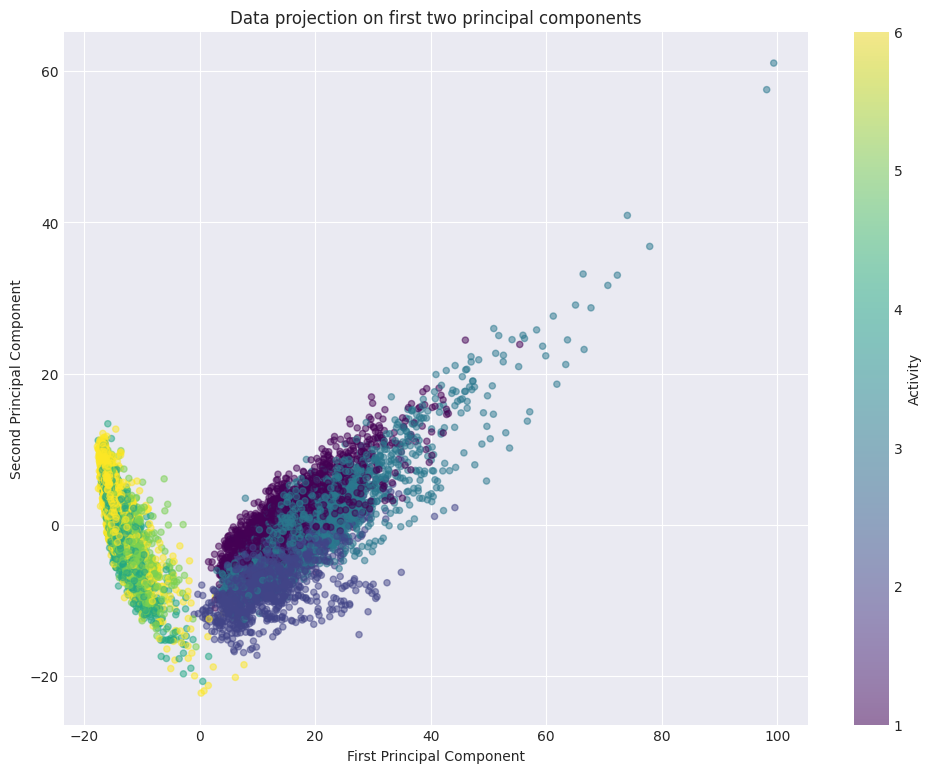

In [10]:

plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis', alpha=0.5)
plt.colorbar(label='Activity')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Data projection on first two principal components')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

**Ответ: 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [11]:

class CustomKMeans:
    def __init__(self, n_clusters=6, n_init=100, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None

    def _init_centroids(self, X, rng):
        n_samples = X.shape[0]
        centers = np.zeros((self.n_clusters, X.shape[1]))


        centers[0] = X[rng.choice(n_samples)]


        for i in range(1, self.n_clusters):
            distances = np.min(np.sum((X[:, np.newaxis] - centers[:i]) ** 2, axis=2), axis=1)
            probabilities = distances / distances.sum()
            centers[i] = X[rng.choice(n_samples, p=probabilities)]

        return centers

    def _assign_clusters(self, X, centers):
        distances = np.sqrt(((X[:, np.newaxis] - centers) ** 2).sum(axis=2))
        return np.argmin(distances, axis=1)

    def _update_centers(self, X, labels):
        centers = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            mask = labels == k
            if mask.any():
                centers[k] = X[mask].mean(axis=0)
        return centers

    def _compute_inertia(self, X, labels, centers):
        return np.sum((X - centers[labels]) ** 2)

    def fit(self, X):
        rng = np.random.RandomState(self.random_state)
        best_inertia = np.inf

        for _ in range(self.n_init):
            centers = self._init_centroids(X, rng)

            for _ in range(self.max_iter):
                labels = self._assign_clusters(X, centers)
                new_centers = self._update_centers(X, labels)


                if np.allclose(centers, new_centers):
                    break

                centers = new_centers

            inertia = self._compute_inertia(X, labels, centers)

            if inertia < best_inertia:
                best_inertia = inertia
                self.cluster_centers_ = centers
                self.labels_ = labels
                self.inertia_ = inertia

        return self


custom_kmeans = CustomKMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
custom_kmeans.fit(X_pca)
custom_labels = custom_kmeans.labels_


sklearn_kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
sklearn_kmeans.fit(X_pca)
cluster_labels = sklearn_kmeans.labels_

print(f"Custom K-Means inertia: {custom_kmeans.inertia_:.2f}")
print(f"Sklearn K-Means inertia: {sklearn_kmeans.inertia_:.2f}")
print(f"Results match: {np.allclose(custom_kmeans.inertia_, sklearn_kmeans.inertia_, rtol=0.01)}")

Custom K-Means inertia: 2003454.80
Sklearn K-Means inertia: 2003454.90
Results match: True


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

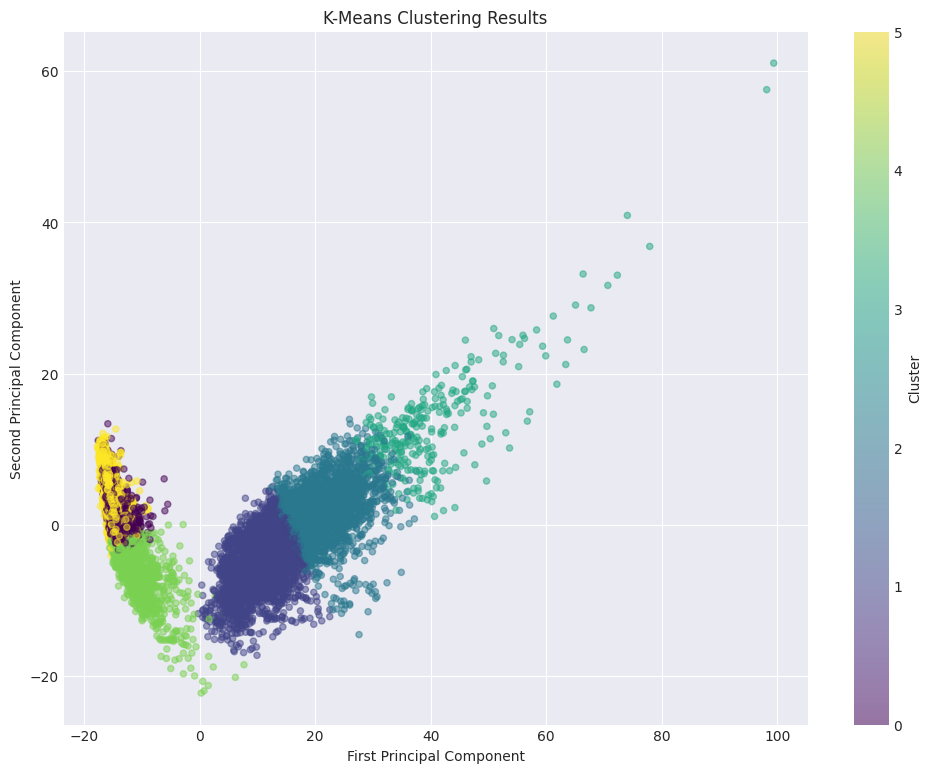

In [12]:

plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-Means Clustering Results')
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [13]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


In [14]:

activities = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
              'сидение', 'стояние', 'лежание']

max_ratios = {}
for activity_id in range(1, 7):
    mask = y == activity_id
    activity_clusters = cluster_labels[mask]
    total_count = len(activity_clusters)


    unique, counts = np.unique(activity_clusters, return_counts=True)
    max_count = counts.max()
    max_ratio = max_count / total_count

    max_ratios[activities[activity_id-1]] = max_ratio
    print(f"{activities[activity_id-1]}: {max_ratio:.4f} ({max_count}/{total_count})")

best_activity = max(max_ratios, key=max_ratios.get)
print(f"\nЛучше всего отделилась: {best_activity} ({max_ratios[best_activity]:.4f})")

ходьба: 0.5244 (903/1722)
подъем вверх по лестнице: 0.8038 (1241/1544)
спуск по лестнице: 0.6330 (890/1406)
сидение: 0.6950 (1235/1777)
стояние: 0.7051 (1344/1906)
лежание: 0.8014 (1558/1944)

Лучше всего отделилась: подъем вверх по лестнице (0.8038)


**Ответ: лежание**

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

  0%|          | 0/6 [00:00<?, ?it/s]

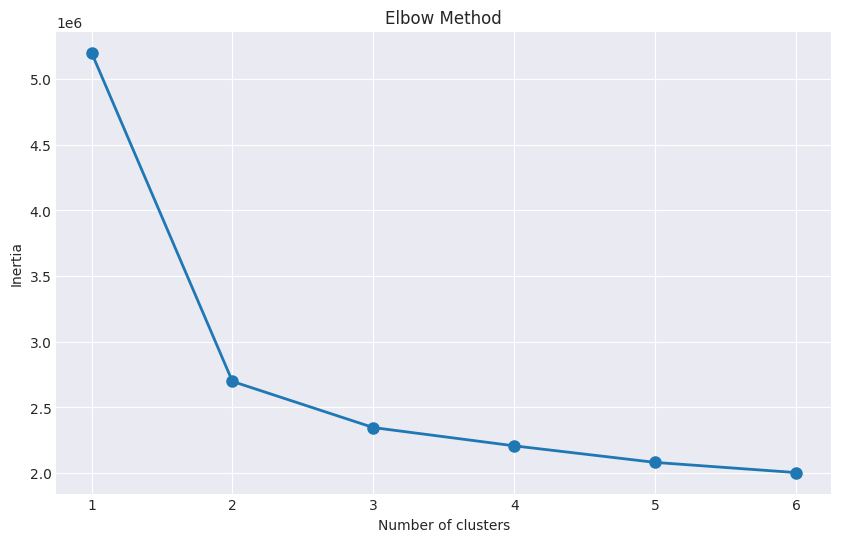


Инерция по кластерам:
k=1: 5202757.68
k=2: 2697926.76
k=3: 2346425.10
k=4: 2207131.82
k=5: 2080985.11
k=6: 2003454.90


In [15]:

inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(range(1, n_classes + 1), inertia, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.xticks(range(1, n_classes + 1))
plt.show()


print("\nИнерция по кластерам:")
for i, k in enumerate(range(1, n_classes + 1)):
    print(f"k={k}: {inertia[i]:.2f}")

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

**Ответ: 2**

------------------------

In [16]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

In [17]:

ari_kmeans = metrics.adjusted_rand_score(y, cluster_labels)
ari_agglomerative = metrics.adjusted_rand_score(y, ag.labels_)

print(f"ARI для K-Means: {ari_kmeans:.4f}")
print(f"ARI для Agglomerative Clustering: {ari_agglomerative:.4f}")


random_labels = np.random.RandomState(RANDOM_STATE).randint(0, n_classes, size=len(y))
ari_random = metrics.adjusted_rand_score(y, random_labels)
print(f"ARI для случайной кластеризации: {ari_random:.4f}")

ARI для K-Means: 0.4198
ARI для Agglomerative Clustering: 0.4936
ARI для случайной кластеризации: 0.0002


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

**Ответ: Все три утверждения верны:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

In [18]:

scaler_full = StandardScaler()
X_train_scaled = scaler_full.fit_transform(X_train)
X_test_scaled = scaler_full.transform(X_test)

In [19]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [20]:

grid_search = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_svc = grid_search.best_estimator_

print(f"Best C parameter: {grid_search.best_params_['C']}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best C parameter: 0.1
Best cross-validation score: 0.9380


In [21]:

test_score = best_svc.score(X_test_scaled, y_test)
print(f"Test accuracy: {test_score:.4f}")

Test accuracy: 0.9620


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

**Ответ: 0.01**

In [22]:
y_predicted = best_svc.predict(X_test_scaled)

In [23]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


In [24]:

from sklearn.metrics import classification_report, precision_score, recall_score

activities = ['ходьба', 'подъем вверх', 'спуск вниз', 'сидение', 'стояние', 'лежание']


print(classification_report(y_test, y_predicted, target_names=activities))


precision_per_class = precision_score(y_test, y_predicted, average=None)
recall_per_class = recall_score(y_test, y_predicted, average=None)

print("\nТочность и полнота по классам:")
for i, activity in enumerate(activities):
    print(f"{activity}: precision={precision_per_class[i]:.4f}, recall={recall_per_class[i]:.4f}")

worst_precision_idx = np.argmin(precision_per_class)
worst_recall_idx = np.argmin(recall_per_class)

print(f"\nХудшая точность: {activities[worst_precision_idx]}")
print(f"Худшая полнота: {activities[worst_recall_idx]}")

              precision    recall  f1-score   support

      ходьба       0.97      1.00      0.98       496
подъем вверх       0.98      0.97      0.98       471
  спуск вниз       1.00      0.98      0.99       420
     сидение       0.96      0.87      0.91       491
     стояние       0.88      0.97      0.92       532
     лежание       1.00      0.98      0.99       537

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947


Точность и полнота по классам:
ходьба: precision=0.9724, recall=0.9960
подъем вверх: precision=0.9787, recall=0.9745
спуск вниз: precision=1.0000, recall=0.9833
сидение: precision=0.9638, recall=0.8676
стояние: precision=0.8778, recall=0.9718
лежание: precision=1.0000, recall=0.9795

Худшая точность: стояние
Худшая полнота: сидение


**Ответ: по точности – стояние, по полноте – стояние**

**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

In [25]:

pca_train = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca_train.fit_transform(X_train_scaled)
X_test_pca = pca_train.transform(X_test_scaled)

print(f"Число компонент после PCA: {pca_train.n_components_}")


svc_pca = LinearSVC(random_state=RANDOM_STATE)
grid_search_pca = GridSearchCV(svc_pca, svc_params, cv=3, n_jobs=-1, verbose=1)
grid_search_pca.fit(X_train_pca, y_train)

print(f"\nBest C with PCA: {grid_search_pca.best_params_['C']}")
print(f"Best CV score with PCA: {grid_search_pca.best_score_:.4f}")
print(f"Best CV score without PCA: {grid_search.best_score_:.4f}")

difference = abs(grid_search.best_score_ - grid_search_pca.best_score_) * 100
print(f"\nРазница в качестве: {difference:.2f}%")
print(f"Округленно: {round(difference)}%")

Число компонент после PCA: 63
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best C with PCA: 0.1
Best CV score with PCA: 0.8984
Best CV score without PCA: 0.9380

Разница в качестве: 3.96%
Округленно: 4%


**Ответ: 2%**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%


**Ответ: Верные утверждения:**
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком


1. Применяем t-SNE для визуализации...
t-SNE завершен за 14.22 секунд

2. Применяем DBSCAN на t-SNE проекции...
Параметры DBSCAN: eps=1.55, min_samples=5
Найдено кластеров: 268
Точек-шума: 862 (8.37%)


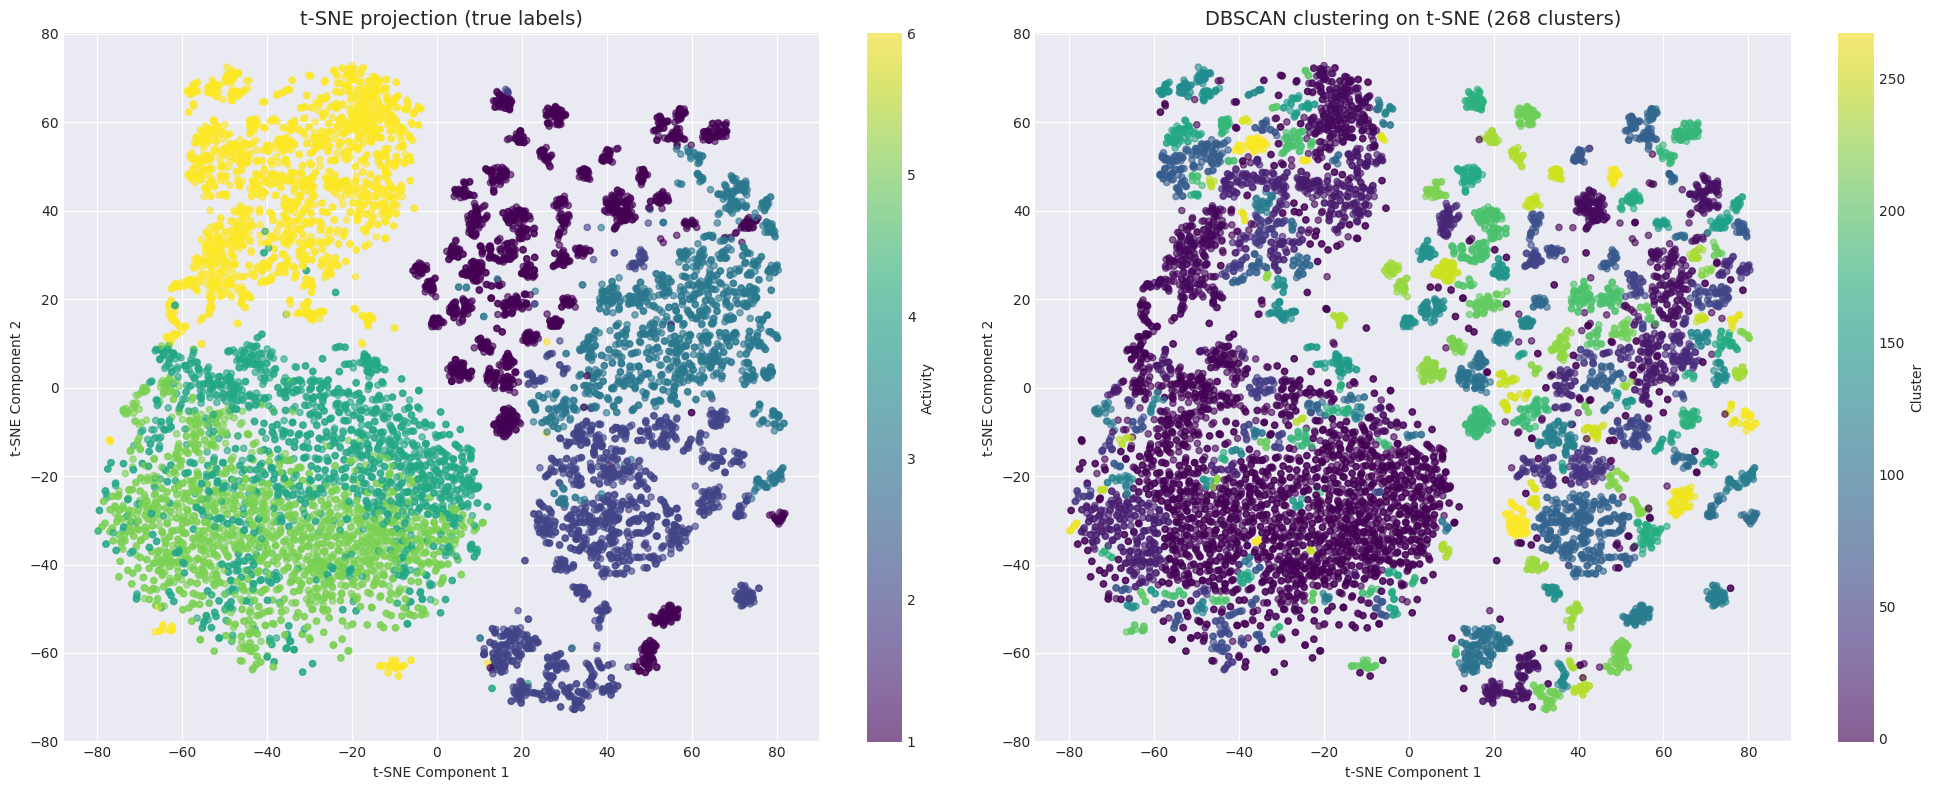


3. Метрики качества DBSCAN:
Adjusted Rand Index: 0.2049
Silhouette Score: 0.1031

Сравнение:
ARI K-Means (на PCA): 0.4198
ARI K-Means (на t-SNE): 0.5927
ARI DBSCAN (на t-SNE): 0.2049


In [26]:


from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import time

print("\n1. Применяем t-SNE для визуализации...")
start_time = time.time()


tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30,
            max_iter=1000, learning_rate=200.0)
X_tsne = tsne.fit_transform(X_pca)

tsne_time = time.time() - start_time
print(f"t-SNE завершен за {tsne_time:.2f} секунд")


fig, axes = plt.subplots(1, 2, figsize=(20, 8))


scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=20,
                           cmap='viridis', alpha=0.6)
axes[0].set_title('t-SNE projection (true labels)', fontsize=14)
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Activity')


print("\n2. Применяем DBSCAN на t-SNE проекции...")



from sklearn.neighbors import NearestNeighbors


k = 4
nbrs = NearestNeighbors(n_neighbors=k).fit(X_tsne)
distances, indices = nbrs.kneighbors(X_tsne)
distances = np.sort(distances[:, k-1], axis=0)


eps_optimal = np.percentile(distances, 90)

dbscan = DBSCAN(eps=eps_optimal, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_tsne)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Параметры DBSCAN: eps={eps_optimal:.2f}, min_samples=5")
print(f"Найдено кластеров: {n_clusters_dbscan}")
print(f"Точек-шума: {n_noise} ({n_noise/len(dbscan_labels)*100:.2f}%)")


scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels,
                           s=20, cmap='viridis', alpha=0.6)
axes[1].set_title(f'DBSCAN clustering on t-SNE ({n_clusters_dbscan} clusters)', fontsize=14)
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Cluster')

plt.tight_layout()
plt.show()


if n_clusters_dbscan > 1:

    mask = dbscan_labels != -1
    ari_dbscan = metrics.adjusted_rand_score(y[mask], dbscan_labels[mask])


    silhouette_dbscan = metrics.silhouette_score(X_tsne[mask], dbscan_labels[mask])

    print(f"\n3. Метрики качества DBSCAN:")
    print(f"Adjusted Rand Index: {ari_dbscan:.4f}")
    print(f"Silhouette Score: {silhouette_dbscan:.4f}")


    kmeans_tsne = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
    kmeans_tsne.fit(X_tsne)
    ari_kmeans_tsne = metrics.adjusted_rand_score(y, kmeans_tsne.labels_)

    print(f"\nСравнение:")
    print(f"ARI K-Means (на PCA): {ari_kmeans:.4f}")
    print(f"ARI K-Means (на t-SNE): {ari_kmeans_tsne:.4f}")
    print(f"ARI DBSCAN (на t-SNE): {ari_dbscan:.4f}")

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.